### Kaggle Competition Notebook
by

**Marion Meyers and**
**Frederik Calsius**

### 0: Importing libraries and datasets

In [23]:
### Libraries
import numpy as np
import pandas as pd
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
### Datasets
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")
# print("shape: of matrix: ", train_data.shape, "\n", train_data.head())
# print(train_data.isna().sum()) #Check if we have any missing values

### 1: Hypothesis Generation

The general hypothesis that is here being investigated is that information about the seasons, the weather and the day and time of the week are enough to accuretely predict the number of bikes that will be rent at a specific moment in time. 


### 2: Visualizing The Data

season : 1, size : 112.39108280254777
season : 2, size : 208.51971110442372
season : 3, size : 237.45096296296296
season : 4, size : 201.0925868001251
[112.39108280254777, 208.51971110442372, 237.45096296296296, 201.0925868001251]


<BarContainer object of 4 artists>

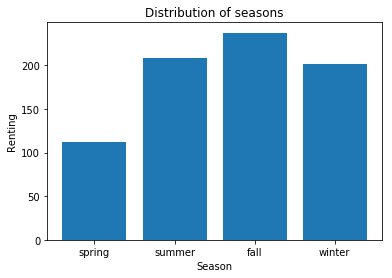

In [25]:
## Seasons
plt.title('Distribution of seasons')
plt.xlabel('Season')
plt.ylabel('Renting')

meanRentings=list()
for season, subset in train_data.groupby('season'):
    print("season : "+str(season)+", size : "+str(subset.cnt.mean()))
    rentingMean = subset.cnt.mean()
    meanRentings.append(rentingMean)

print(meanRentings)
plt.bar(['spring','summer','fall','winter'], meanRentings)

We can see that fall and summer are the 2 seasons where most bikes are rent. 
It is nevertheless interesting to notice that spring is the lowest seasons while one could expect winter to be the lowest seasons when it comes to bike rentals. 

However, as a general comment, we see that the bike rentals indeed vary quite importantly depending on the seasons, which makes us think that this is indeed a good feature to keep in mind when trying to predict the number of bikes rent. 


weather : 1, size : 206.51547951582867
weather : 2, size : 176.18866253321522
weather : 3, size : 112.82542694497154
weather : 4, size : 29.5
[206.51547951582867, 176.18866253321522, 112.82542694497154, 29.5]


<BarContainer object of 4 artists>

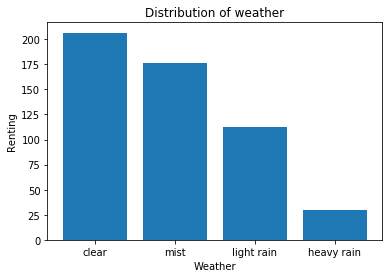

In [26]:
## Weather
plt.title('Distribution of weather')
plt.xlabel('Weather')
plt.ylabel('Renting')

meanRentings=list()
for weather, subset in train_data.groupby('weathersit'):
    print("weather : "+str(weather)+", size : "+str(subset.cnt.mean()))
    rentingMean = subset.cnt.mean()
    meanRentings.append(rentingMean)

print(meanRentings)
plt.bar(['clear','mist','light rain','heavy rain'], meanRentings)


As expected, the better the weather, the more bikes are rent. This makes us think that the weather forecast is an important feature when predicting bike rentals. 

It would nevertheless be interesting to see the correlation between the season and the weather. If the two features are too heavily correlated, they would bring redundant information and might even confuse the prediciton algorithm

In [27]:
##CORRELATION BETWEEN SEASON AND WEATHER 
train_data['season'].corr(train_data['weathersit'])


-0.009963980605403648

The two features are not heavily correlated at all, which means we will keep both features in our data. 

Let us now go more in details into the different subparts of the weather -> temperature, humidity and windspeed

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


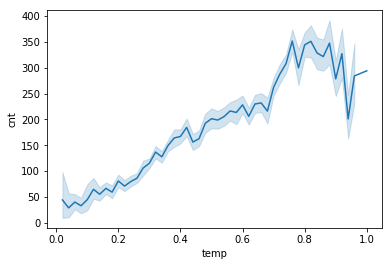

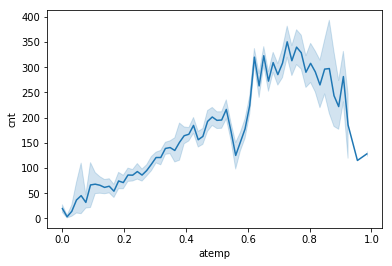

In [28]:
## RENTALS WITH RESPECT TO TEMPERATURE
## Temperature is normalized between 0 and 1
x = train_data['temp']
y = train_data['cnt']
sns.lineplot(x=x, y=y, data=train_data)
plt.show()

## RENTALS WITH RESPECT TO 'FELT' TEMPERATURE
x = train_data['atemp']
y = train_data['cnt']
sns.lineplot(x=x, y=y, data=train_data)
plt.show()


We can observe that both the normalized temperature and the 'felt' temperature show relatively similar graph with regards to their influence on the number of bikes rent. Let us then calculate their both correlation to 'cnt' as well as their correlation between each other, in order to decide if one of the 2 features can be left out because of redundancy. 

In [29]:
print("corr between temp and cnt : "+str(train_data['temp'].corr(train_data['cnt'])))
print("corr between atemp and cnt : "+str(train_data['atemp'].corr(train_data['cnt'])))
print("corr between temp and atemp : "+str(train_data['temp'].corr(train_data['atemp'])))

corr between temp and cnt : 0.40654037832188034
corr between atemp and cnt : 0.40303267185789005
corr between temp and atemp : 0.9879992361817085


Temp and ATemp have a very strong correlation which we can leave out one of the two for our predictor. 
Since Temp has a slightly stronger correlation with 'cnt', we will choose it as the remaining feature in our analysis. 

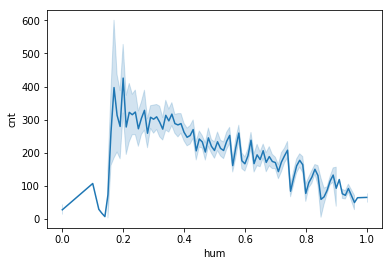

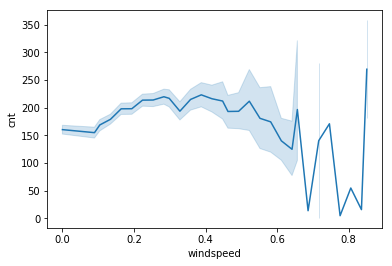

In [30]:
#Influence of Humidity and Windspeed
x = train_data['hum']
y = train_data['cnt']
sns.lineplot(x=x, y=y, data=train_data)
plt.show()

x = train_data['windspeed']
y = train_data['cnt']
sns.lineplot(x=x, y=y, data=train_data)
plt.show()


In both graphs, some parts can be left out of the analysis: the parts that only has a straight blue line at the extremes. Those are extremes that we don't have a lot of data on. Thus we should not consider these as relevant. 

Other than that, we see a negative correlation between both the humidity and the windspeed on the number of bikes rent. 

Are those 2 features strongly correlated with the weather? Enough for us to not consider them on their own? 

In [31]:
print("corr between humidity and weather : "+str(train_data['hum'].corr(train_data['weathersit'])))
print("corr between windspeed and weather : "+str(train_data['windspeed'].corr(train_data['weathersit'])))
print("corr between humidity and windspeed : "+str(train_data['hum'].corr(train_data['windspeed'])))


corr between humidity and weather : 0.4151429793621579
corr between windspeed and weather : 0.03118513211036063
corr between humidity and windspeed : -0.2858314248351923


The weather and humidity are quite correlated but not strongly enough for us to discard any of those features. 

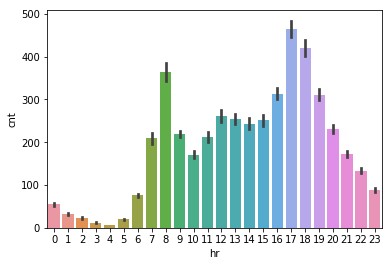

In [32]:
## Hourly
x = train_data['hr']
y = train_data['cnt']
sns.barplot(x=x, y=y)
plt.show()
## Around 8h00 and 17h00 - 18h00 it's peak moment


We observe a lot of variations in the number of bike rent during the day. 8am and 17h-18h seem to be corresponding to 2 peaks in bike rentals. 

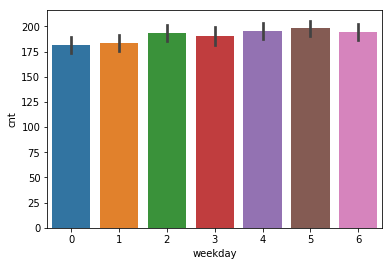

corr between weekday and weather situation : 0.0009392496582903871


In [33]:
## Daily
x = train_data['weekday']
y = train_data['cnt']
sns.barplot(x=x, y=y)
plt.show()

print("corr between weekday and weather situation : " + str(train_data['weekday'].corr(train_data['weathersit'])))

The amount of bikes rented is pretty consistent per day. We also see that the correlation between weekday and count is very close to 0, which means that this feature on its own is not very indicative of the number of bike rentals. 

Nevertheless, it would be interesting to look at the evolution of the number of rented bikes each day. One could expect bikes to be rented at different times on Mondays and Saturdays. 

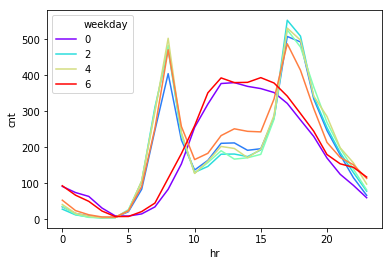

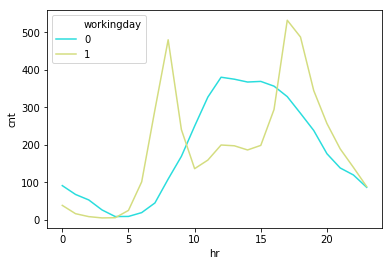

In [34]:
## Rentals Per hour Per day (using 'weekday' feature)
daily_rentals = pd.DataFrame(train_data.groupby(['hr', 'weekday'], sort = True)['cnt'].mean()).reset_index()
x = daily_rentals['hr']
y = daily_rentals['cnt']
h = daily_rentals['weekday']
sns_plt = sns.lineplot(x=x, y=y, hue = h, data = daily_rentals, palette='rainbow')
## 0 and 6 are Sunday and Saturday respectively. This plot shows the difference in rental behavior during workdays and weekends
plt.show()


## Rentals Per hour Per day (using 'workingday' feature)
daily_rentals = pd.DataFrame(train_data.groupby(['hr', 'workingday'], sort = True)['cnt'].mean()).reset_index()
x = daily_rentals['hr']
y = daily_rentals['cnt']
h = daily_rentals['workingday']
sns_plt = sns.lineplot(x=x, y=y, hue = h, data = daily_rentals, palette='rainbow')
## 0 and 6 are Sunday and Saturday respectively. This plot shows the difference in rental behavior during workdays and weekends
plt.show()


As one could expect, we see the bikes are rented in a different way during the week and in the weekend. This shows that the feature 'workingday' is probably of strong relevance for predicting bike rentals. Nevetheless, since we see that every day of the week shows the same bike rental pattern (and both saturday and sunday follow the same pattern as well), we can probably get rid of the feature 'weekday' and only consider 'workingday'.

### 3: Hypothesis Testing

In order to test the hypothesis, we will try to build predictors using the features explained above and see if we can accurately enough predict the number of bikes rent. If this is the case, our hypothesis that "information about season, weather as well as day and time are enough to predict the bike rental amount". 

### 4: Model Building 

Different algorithms as well as feature selections have been performed. 

Algorithms:
1) Linear Regression
2) Random Forest
3) Gradient Boosting
4) Combination of Random Forest and Gradient Boosting

We have also trained our algorithms both when leaving out the features mentionned above ('atemp' and 'weekday') and when leaving all features in. 

Lastly, we have performed k-cross validation on all our methods to make sure that we were not overfitting our data. 

**Linear Regression**

In [35]:
#Without K-fold validation method
#output_data = train_data.loc[:, 'cnt']
#input_data = train_data.drop(['cnt'], axis=1)

#With k-fold validation method
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['cnt'], axis=1), train_data.loc[:, 'cnt'], test_size=0.4, random_state=0)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
test_data = test_data

#leaving out the features
# X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['cnt', 'weekday', 'atemp'], axis=1), train_data.loc[:, 'cnt'], test_size=0.4, random_state=0)
# test_data = test_data.drop(['weekday', 'atemp'], axis = 1)


As you can see, currently the training data and testing data contain all the features that are available. This contradicts with what we mentioned above, where we would leave highly correlated features out. 
The code that leaves the features out is currently commented out, yet it's available to try out right-away. 

The reason why we have chosen to use all features in the end is because we found that this yields better final scores (by +/- 10 points). This is not the result we had expected and it is therefore necessary to mention it. 

In [36]:
### Linear Regression
lin_reg = LinearRegression().fit(X_train, y_train)
prediction = lin_reg.predict(test_data)
print("prediction", prediction.shape)

print("k-fold score : "+str(lin_reg.score(X_test,y_test)))

prediction (4344,)
k-fold score : 0.330343907522194


In [37]:
### Setting up the output doc
id_column = [x for x in range(1, 4345)]
cnt_column = ['cnt']
prediction_df = pd.DataFrame(index=id_column, columns=cnt_column)
prediction_df.columns.name = 'Id'
prediction_df['cnt'] = [int(pred) for pred in prediction]

# to make sure each value is 0 or higher
prediction_df = prediction_df.clip(lower = 0)

print("prediction df")
print(prediction_df.head())

# ### Putting everything in the output file
# prediction_df.to_csv('./output.csv', index_label='Id')

prediction df
Id  cnt
1    65
2    74
3   190
4   133
5   260


We see that the accuracy score of the Linear Regression performed here above with k-cross validation is only 0.33, which m=doesn't make it a good predictor for our purpose. 

**Random Decision Forest**

In [54]:
### Random Decision Forest
forest_reg = RandomForestRegressor(max_depth=18, max_features=6, min_samples_split=4, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=415, warm_start=True)

forest_reg.fit(X_train, y_train)
forest_pred = forest_reg.predict(test_data)
print("random forest: ", forest_pred.shape)
print("k-fold score : "+str(forest_reg.score(X_test,y_test)))
#print(forest_reg.decision_path())

#Analyse the importance the algorithm gave to the different features
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': forest_reg.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

random forest:  (4344,)
k-fold score : 0.8498274772960496


,feature,importance
2,hr,0.547001
8,atemp,0.097608
7,temp,0.094388
9,hum,0.067942
5,workingday,0.051741


In [39]:
### Setting up the output doc
id_column = [x for x in range(1, 4345)]
cnt_column = ['cnt']
forest_df = pd.DataFrame(index=id_column, columns=cnt_column)
forest_df.columns.name = 'Id'
forest_df['cnt'] = [int(pred) for pred in forest_pred]

# to make sure each value is 0 or higher
forest_df = forest_df.clip(lower = 0)

print("random forest df")
print(forest_df.head())

### Putting everything in the output file
# forest_df.to_csv('./output2.csv', index_label='Id')

random forest df
Id  cnt
1     4
2   184
3   184
4    36
5   109


A score of 0.849 is quite high for a predictor, which makes the Random Forest already a good fit for our bike rental prediciton. Let's see if we can do even better. 

Furthermore, we can observe that the features that seem to have the greast decision impact on the predictor are 'hour' and both the temperature features. 

**Gradient Boosting Regressor**

In [55]:
### Gradient Boosting
#input_data = input_data.drop(['atemp'], axis=1)
#print(test_data.head())
#test_data = test_data.drop(['atemp'], axis=1)
# X_train = X_train.drop(['atemp'], axis=1)
# X_test = X_test.drop(['atemp'], axis=1)

grad_boost = GradientBoostingRegressor(n_estimators=7000,alpha=0.01, max_features=6, warm_start=True)

grad_boost.fit(X_train, y_train)
grad_pred = grad_boost.predict(test_data)
print("Gradient Boosting Regressor: ", grad_pred.shape)
print("k-fold result : "+str(grad_boost.score(X_test,y_test)))

Gradient Boosting Regressor:  (4344,)
k-fold result : 0.8602178898095671


In [56]:
### Output to the document 
id_column = [x for x in range(1, 4345)]
cnt_column = ['cnt']
gradient_df = pd.DataFrame(index=id_column, columns=cnt_column)
gradient_df.columns.name = 'Id'
gradient_df['cnt'] = [int(pred) for pred in grad_pred]

# to make sure each value is 0 or higher
gradient_df = gradient_df.clip(lower = 0)

print("Gradient boosting: ")
print(gradient_df.head())

#Analyse the importance the algorithm gave to the different features
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': grad_boost.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

# gradient_df.to_csv('./output3.csv', index_label='Id')

Gradient boosting: 
Id  cnt
1    20
2   182
3   270
4    13
5    69


,feature,importance
2,hr,0.569132
8,atemp,0.131707
7,temp,0.066792
9,hum,0.064963
5,workingday,0.057549


Gradient Boosting Regressor gives us the best result so far (0.86), but the random forest method with its given tune comes very close. We can also obersve that the same features have been given more importance than others in the gradient boosting when compared to the random forest (hour and temperature, followed by working day and humidity)

We noticed that both predictors obtain an almost equal scoring on the bike dataset. When we inspected the output of the predictors we saw that one was generally predicting higher than the other one. This made us curious for what would happen when we combined / averaged the results of both the predictors. Eventually this led us to our best scoring results


**Combined Results**

In [49]:
### Setting up everything for the combined results
result_df = pd.DataFrame(index=id_column, columns=cnt_column)
# result_df['cnt'] = [int(pred) for pred in grad_pred]
result_df = result_df.clip(lower = 0)
result_df.columns.name = 'Id'
result_pred = grad_pred

fresh = []

In [50]:
### Filling the list with the combined results
for i in range (len(grad_pred)):
    if grad_pred[i]/(grad_pred[i]+forest_pred[i]) > 0.2 and grad_pred[i]/(grad_pred[i]+forest_pred[i]) < 0.8:
        fresh.append((grad_pred[i]+forest_pred[i])/2)
    elif grad_pred[i]/(grad_pred[i]+forest_pred[i]) > 0.8:
        fresh.append((grad_pred[i] + forest_pred[i])/2.4)
    elif grad_pred[i]/(grad_pred[i]+forest_pred[i]) < 0.2:
        fresh.append((grad_pred[i] + forest_pred[i]) / 1.6)
    else:
        fresh.append(grad_pred[i])

In [51]:
print("length of results is: ", len(fresh))
result_df['cnt'] = [int(f) for f in fresh]

# to make sure each value is 0 or higher
result_df = result_df.clip(lower = 0)

print("Combined results:")
print(result_df.head())

# result_df.to_csv('./output3_combo.csv', index_label='Id')

length of results is:  4344
Combined results:
Id  cnt
1    10
2   184
3   227
4    26
5    92


In conclusion, we see that the features that were provided were indeed enough to accurately predict the bike rental amount. We have tried different algorithms, have performed cross validation to avoid overfitting and have also given insights in to the feature selections. We have encountered some unexpected results: the dropping out of 'redundant' features (temp and weekday) did not yield better results. However, we have achieved an accuracy of more than 0.85 using Gradient Boosting and have even improved our score even more by combining the predictions of the Random Forest with the Gradient Boosting predictions. 
